# Model Performance Comparison

This notebook visualizes and compares the performance of different models on the LAMBADA and C4 benchmarks. We'll look at the perplexity scores for each model, which is a common metric for evaluating language models (lower perplexity is better).

## Import Required Libraries

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path

# Set the style for plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

## Load Model Evaluation Data

We'll load the evaluation results from JSON files for each model and benchmark.

In [2]:
def load_evaluation_results(snapshots_dir='snapshots'):
    """Load evaluation results from JSON files in the snapshots directory."""
    results = []
    
    # Get all model directories
    model_dirs = [d for d in Path(snapshots_dir).iterdir() if d.is_dir()]
    
    for model_dir in model_dirs:
        # Find evaluation files for this model
        eval_files = list(model_dir.glob(f"*_perplexity_eval_on_*.json"))
        
        for eval_file in eval_files:
            with open(eval_file, 'r') as f:
                data = json.load(f)
                
                # Extract the key information
                results.append({
                    'model_name': data['model_name'],
                    'benchmark': data['dataset_name'],
                    'perplexity': data['perplexity'],
                    'ce_loss': data['ce_loss'],
                    'tokens_per_second': data['tokens_per_second']
                })
    
    return pd.DataFrame(results)

# Load the evaluation results
results_df = load_evaluation_results()
results_df.head()

,model_name,benchmark,perplexity,ce_loss,tokens_per_second
0,fineweb-frobenius-only-xlstm,c4,566.254161,6.339043,8485.259451
1,fineweb-frobenius-only-xlstm,lambada_openai,3374.903807,8.124122,3428.883925
2,fineweb-xlstm,lambada_openai,12011.402571,9.393612,3696.772211
3,fineweb-xlstm,c4,1575.898685,7.362581,8575.031909
4,smollm2-moxe-baseline,lambada_openai,220322.161729,12.302846,6827.827863


## Data Preprocessing

Let's clean up the model names to make them more readable for the plots.

In [3]:
# Clean up model names for better display
results_df['display_name'] = results_df['model_name'].apply(lambda x: x.replace('-', ' ').title())

# Sort the results by model name for consistency
results_df = results_df.sort_values('model_name')

# Show the unique benchmarks and models
print(f"Benchmarks: {results_df['benchmark'].unique()}")
print(f"Models: {results_df['display_name'].unique()}")

Benchmarks: ['c4' 'lambada_openai']
Models: ['Fineweb Frobenius Only Xlstm' 'Fineweb Xlstm' 'Smollm2 Moxe Baseline']


## Visualization: Perplexity Comparison

We'll create bar plots to compare perplexity (lower is better) across models for each benchmark.

In [4]:
# Function to create a bar plot for perplexity comparison
def plot_perplexity_comparison(df, benchmark, figsize=(12, 6), log_scale=True):
    # Filter data for the specific benchmark
    benchmark_df = df[df['benchmark'] == benchmark].copy()
    
    # Sort by perplexity (ascending) so better models appear first
    benchmark_df = benchmark_df.sort_values('perplexity')
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a bar plot
    colors = sns.color_palette("viridis", len(benchmark_df))
    bars = ax.bar(benchmark_df['display_name'], benchmark_df['perplexity'], color=colors)
    
    # Use log scale for perplexity if specified (often more informative)
    if log_scale and all(benchmark_df['perplexity'] > 0):
        ax.set_yscale('log')
    
    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
                f'{height:.2f}', ha='center', va='bottom', rotation=0)
    
    # Set labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel('Perplexity (lower is better)')
    ax.set_title(f'Model Perplexity Comparison on {benchmark.upper()} Benchmark')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

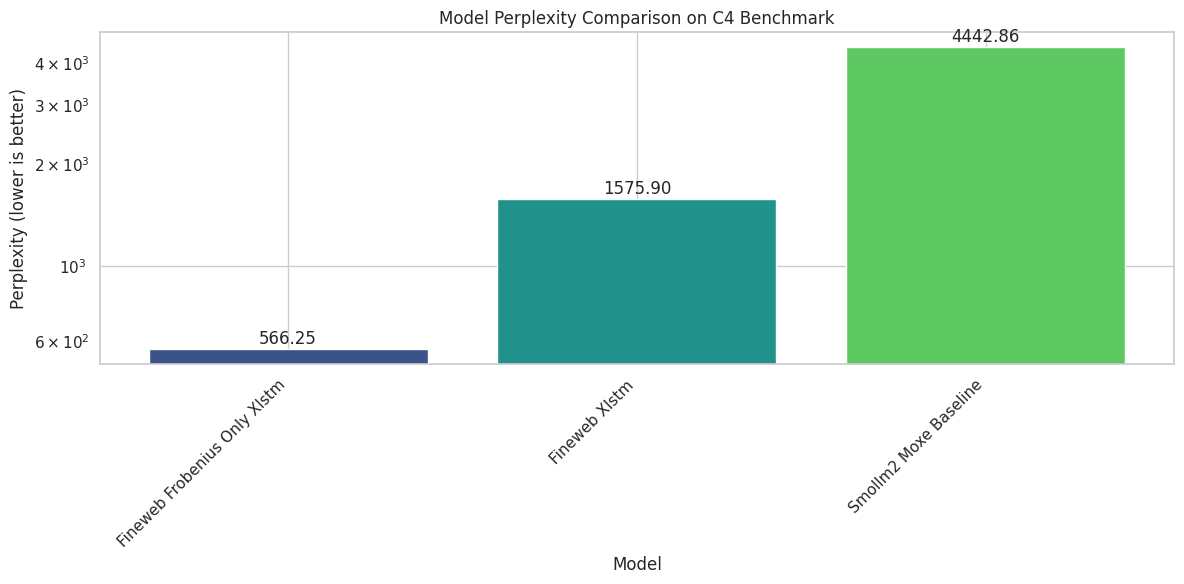

In [5]:
# Plot perplexity for C4 benchmark
c4_fig = plot_perplexity_comparison(results_df, 'c4')
plt.show()

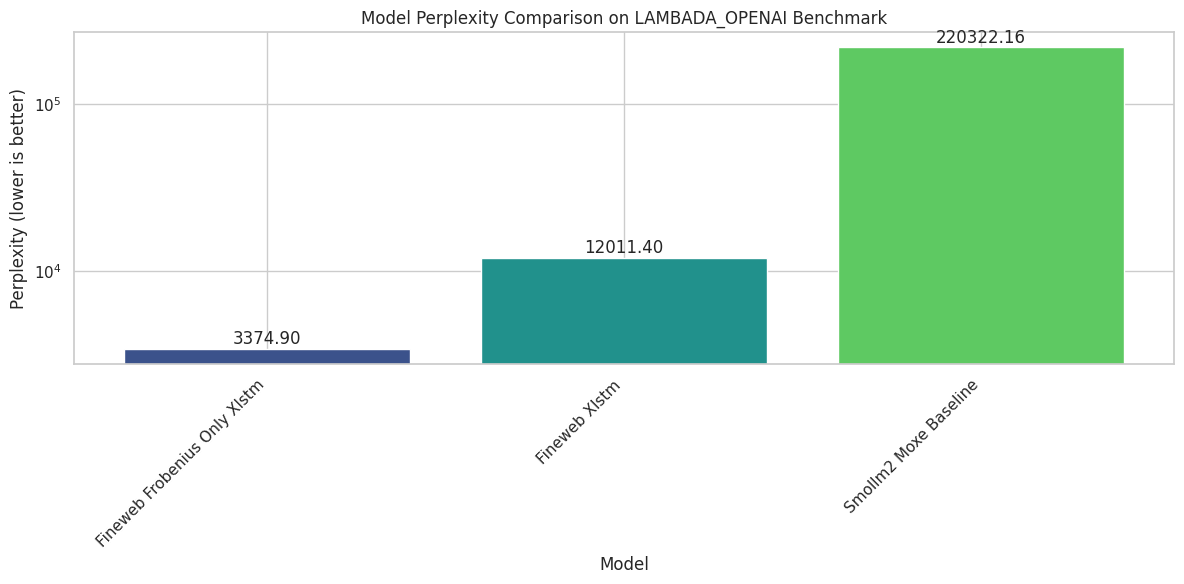

In [6]:
# Plot perplexity for LAMBADA benchmark
lambada_fig = plot_perplexity_comparison(results_df, 'lambada_openai')
plt.show()

## Combined Visualization

Now let's create a grouped bar plot to compare both benchmarks side by side.

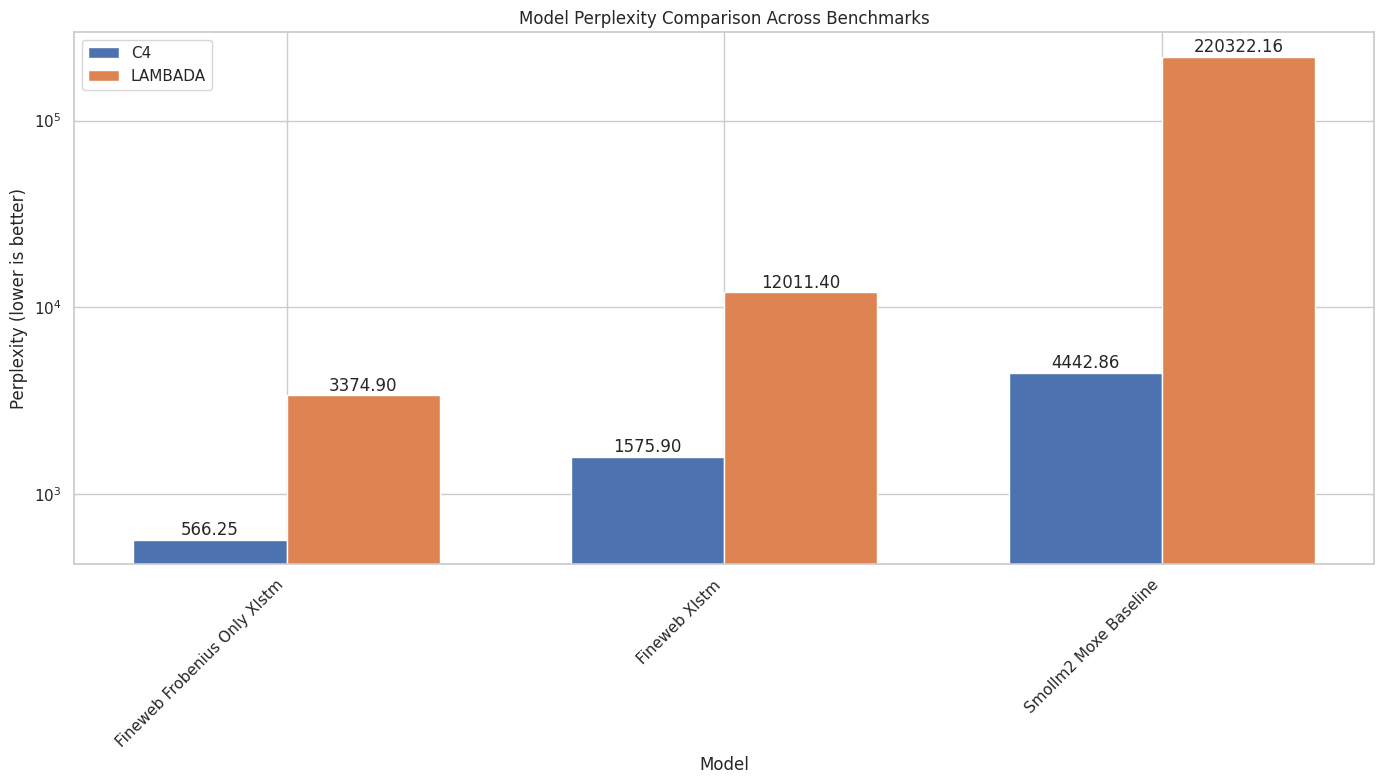

In [7]:
def plot_combined_comparison(df, figsize=(14, 8), log_scale=True):
    # Pivot the data to get benchmarks as columns and models as rows
    pivot_df = df.pivot(index='display_name', columns='benchmark', values='perplexity').reset_index()
    
    # Define width of bars
    width = 0.35
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set positions for bars
    x = range(len(pivot_df['display_name']))
    
    # Create bars
    bars1 = ax.bar([i - width/2 for i in x], pivot_df['c4'], width, label='C4')
    bars2 = ax.bar([i + width/2 for i in x], pivot_df['lambada_openai'], width, label='LAMBADA')
    
    # Use log scale for perplexity if specified
    if log_scale and all(pivot_df['c4'] > 0) and all(pivot_df['lambada_openai'] > 0):
        ax.set_yscale('log')
    
    # Add value labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + (height * 0.01),
                    f'{height:.2f}', ha='center', va='bottom', rotation=0)
    
    add_labels(bars1)
    add_labels(bars2)
    
    # Set labels, title and legend
    ax.set_xlabel('Model')
    ax.set_ylabel('Perplexity (lower is better)')
    ax.set_title('Model Perplexity Comparison Across Benchmarks')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df['display_name'], rotation=45, ha='right')
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Create combined plot
combined_fig = plot_combined_comparison(results_df)
plt.show()

## Performance Analysis

Let's analyze the model performance in more depth.

In [8]:
# Create a summary table
pivot_table = results_df.pivot_table(
    index='display_name', 
    columns='benchmark', 
    values=['perplexity', 'tokens_per_second']
).round(2)

# Display the summary table
pivot_table

perplexity                tokens_per_second  \
benchmark                            c4 lambada_openai                c4   
display_name                                                               
Fineweb Frobenius Only Xlstm     566.25        3374.90           8485.26   
Fineweb Xlstm                   1575.90       12011.40           8575.03   
Smollm2 Moxe Baseline           4442.86      220322.16          15758.37   

                                             
benchmark                    lambada_openai  
display_name                                 
Fineweb Frobenius Only Xlstm        3428.88  
Fineweb Xlstm                       3696.77  
Smollm2 Moxe Baseline               6827.83

In [9]:
# Calculate the best model for each benchmark
best_models = results_df.loc[results_df.groupby('benchmark')['perplexity'].idxmin()]
best_models[['benchmark', 'display_name', 'perplexity']]

,benchmark,display_name,perplexity
0,c4,Fineweb Frobenius Only Xlstm,566.254161
1,lambada_openai,Fineweb Frobenius Only Xlstm,3374.903807


## Inference Speed Comparison

Let's also compare the inference speed (tokens per second) across models.

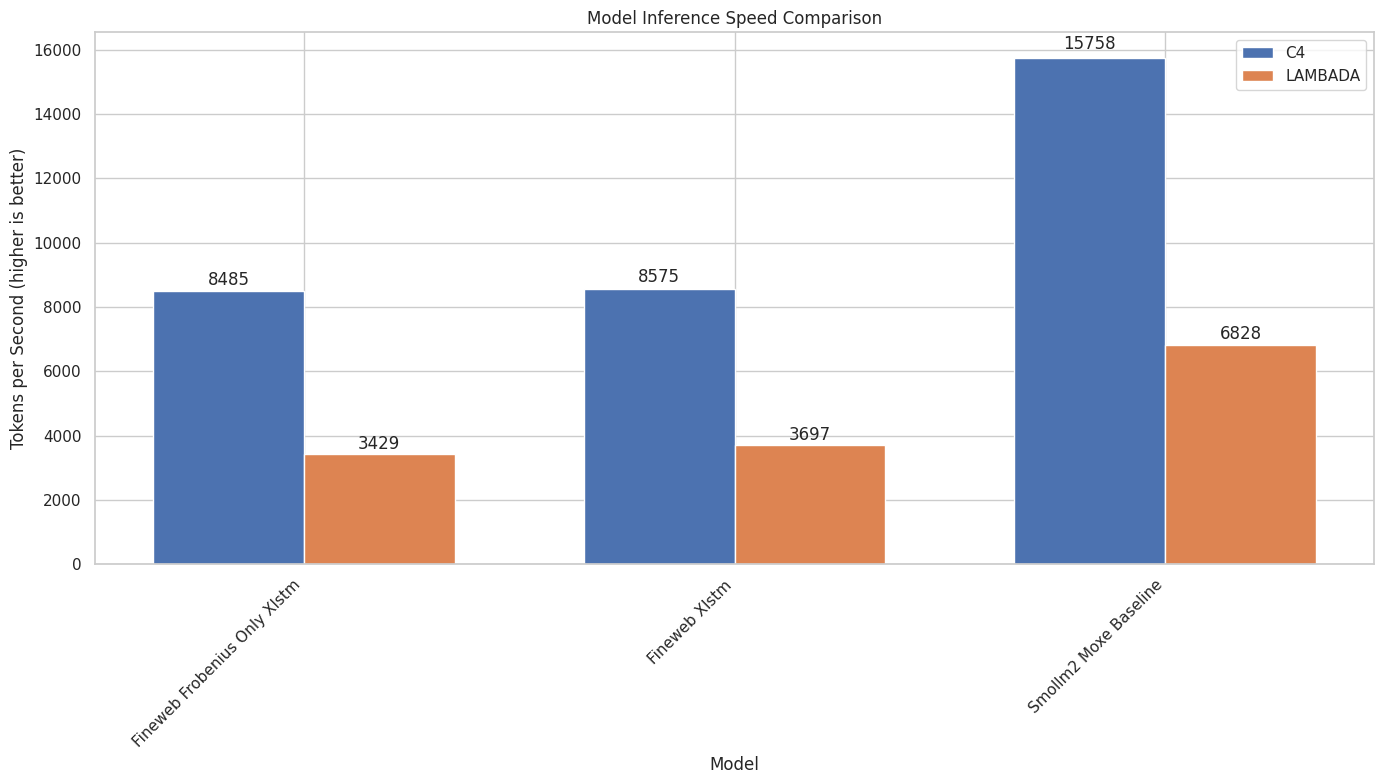

In [10]:
def plot_speed_comparison(df, figsize=(14, 8)):
    # Pivot the data to get benchmarks as columns and models as rows
    pivot_df = df.pivot(index='display_name', columns='benchmark', values='tokens_per_second').reset_index()
    
    # Define width of bars
    width = 0.35
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set positions for bars
    x = range(len(pivot_df['display_name']))
    
    # Create bars
    bars1 = ax.bar([i - width/2 for i in x], pivot_df['c4'], width, label='C4')
    bars2 = ax.bar([i + width/2 for i in x], pivot_df['lambada_openai'], width, label='LAMBADA')
    
    # Add value labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + (height * 0.01),
                    f'{height:.0f}', ha='center', va='bottom', rotation=0)
    
    add_labels(bars1)
    add_labels(bars2)
    
    # Set labels, title and legend
    ax.set_xlabel('Model')
    ax.set_ylabel('Tokens per Second (higher is better)')
    ax.set_title('Model Inference Speed Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df['display_name'], rotation=45, ha='right')
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Create speed comparison plot
speed_fig = plot_speed_comparison(results_df)
plt.show()

## Conclusion

This notebook has analyzed and visualized the performance of various models across the C4 and LAMBADA benchmarks. We've compared perplexity scores (lower is better) and inference speeds (tokens per second, higher is better).

For the best evaluation of model quality:
1. Perplexity is the primary metric for measuring language model quality
2. C4 is a general text benchmark
3. LAMBADA is more focused on long-range dependencies and contextual understanding

The visualizations above show which models perform best on each benchmark, providing insights into their relative strengths and capabilities.